In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch import sigmoid

In [8]:
# plot func
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
np.set_printoptions(precision=2)
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    plt.figure()
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
def plot_roc(ytrue, yprob):
    mean_fpr = np.linspace(0, 1, 100)

    i = 0

    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = metrics.roc_curve(ytrue, yprob[:, 1])


    roc_auc = metrics.auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, lw=2, alpha=0.3,color='r',
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='b',
             label='Chance', alpha=.8)

    

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()


In [9]:
# Factor Machine Data
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris,fetch_kddcup99,make_classification
from sklearn.model_selection import train_test_split,KFold
from sklearn.linear_model import LogisticRegression,stochastic_gradient
from sklearn.metrics import classification_report

xdata,ydata = make_classification(n_samples=10000, n_features=5, n_classes=2, random_state=None)

coef  = np.array([0.0,0.0,0.0, 0.0,0.0])
ydata = np.matmul(xdata,coef) + xdata[:,1]*xdata[:,2] + xdata[:,2] *xdata[:,3] + xdata[:,1] *xdata[:,3]
ydata = (ydata > np.median(ydata)).astype(np.int)
print(ydata.sum())

Xt = torch.from_numpy(xdata.astype(np.float32))
yt = torch.from_numpy(ydata.astype(np.float32))

5000


In [24]:
class FactorizationMachine(nn.Module):
    def __init__(self,  withCuda=True):
        super(FactorizationMachine, self).__init__()
        
        self.linear = nn.Linear(5,2)
        self.quad   = nn.Bilinear(5,5,2)
        
        
        
    def forward(self, X):
        
        # The linear part
        phi_pl = self.linear(X)
        
        # The Quadratic-FM part using the O(kn) formulation from Steffen Rendle
        phi_pq = self.quad(X,X)
        
        phi = phi_pl + phi_pq

        return phi
        

In [25]:
FM   = FactorizationMachine()
num_epochs = 2000
ytar = yt.long()
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.SGD(FM.parameters(), lr=0.05)  
for epoch in range(num_epochs):
    yout = FM(Xt)
    loss = criterion(yout, ytar)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % (num_epochs/20) == 0:
        print ('Epoch [{0}/{1}], Loss: {2}' 
                   .format(epoch+1, num_epochs, loss.item()))
    

Epoch [1/2000], Loss: 1.8746427297592163
Epoch [101/2000], Loss: 0.19113944470882416
Epoch [201/2000], Loss: 0.14924880862236023
Epoch [301/2000], Loss: 0.12859001755714417
Epoch [401/2000], Loss: 0.11551379412412643
Epoch [501/2000], Loss: 0.1062396839261055
Epoch [601/2000], Loss: 0.09920500963926315
Epoch [701/2000], Loss: 0.0936233401298523
Epoch [801/2000], Loss: 0.0890488252043724
Epoch [901/2000], Loss: 0.08520680665969849
Epoch [1001/2000], Loss: 0.0819176584482193
Epoch [1101/2000], Loss: 0.07905812561511993
Epoch [1201/2000], Loss: 0.07654083520174026
Epoch [1301/2000], Loss: 0.07430114597082138
Epoch [1401/2000], Loss: 0.07229048758745193
Epoch [1501/2000], Loss: 0.07047158479690552
Epoch [1601/2000], Loss: 0.06881499290466309
Epoch [1701/2000], Loss: 0.06729751825332642
Epoch [1801/2000], Loss: 0.06590036302804947
Epoch [1901/2000], Loss: 0.064608134329319


Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

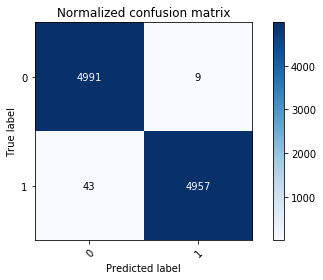

In [26]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    ypre = FM(Xt)
    _, predicted = torch.max(ypre.data, 1)
plot_confusion_matrix(ydata, predicted,classes=np.array([0,1]), normalize=False,
                      title='Normalized confusion matrix')

In [27]:
torch.max(ypre.data, 1)

torch.return_types.max(
values=tensor([5.1897, 1.1835, 1.3435,  ..., 3.9022, 9.9992, 1.1903]),
indices=tensor([1, 0, 1,  ..., 0, 1, 0]))